In [3]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from seaborn.palettes import SEABORN_PALETTES
import pandas as pd
import matplotlib
matplotlib.style.use('default')

In [4]:
# Labels for plots
RG_LABELS = {
    "RQT": "QT-",
    "QG": "QG-",
    "PD": "PD-"
}

LAYER_LINESTYLES = {
    "tucker": (0, (1.5, 1)),
    "cp-shared": "dotted",
    "cp": "-",
    "cp-shared-new": "dashdot"
}

LAYER_MARKERS = {
    "cp": "v",
    "tucker": "o",
    "cp-shared": "d",
    "cp-shared-new": "P"
}

LAYER_MARKERSIZE = {
    "cp": 10,
    "tucker": 10,
    "cp-shared": 12,
    "cp-shared-new": 10
}

LAYER_LABELS = {
    "cp": "CP",
    "tucker": "Tucker",
    "cp-shared-new": "$\\text{CP}^{\\text{S}}$"
}

PALETTE = SEABORN_PALETTES["colorblind"]
RG_COLORS = {
    "PD": PALETTE[0],
    "QG": PALETTE[1],
    "RQT": PALETTE[2]
}

DATASET_LABEL = {
    "mnist": "$\\text{Mnist}$",
    "fashion_mnist": "$\\text{Fashion Mnist}$",
    "celeba": "$\\text{CelebA}$"
}

In [5]:
def benchmarking_plot(benchmarking_results_path: str, benchmarking_save_path: str,
                      min_k = 1, max_k = 4096, line_tickness=2, tick_size=10, legend_size=18,
                      layer_labels=LAYER_LABELS):

    # Matplotlib settings
    matplotlib.rcParams.update({'font.size': 18})
    X_NAME: str = "k"

    Y_LABELS = {
        "test-time": "Test Time (ms)",
        "train-time": "Train Time (ms)",
        "test-space": "Test Memory (GB)",
        "train-space": "Train Memory (GB)"
    }

    results_df = pd.read_csv(benchmarking_results_path)

    fig, axes = plt.subplots(nrows=1, ncols=4)

    for plot_n, y_name in enumerate(Y_LABELS):

        ax = axes[plot_n]
        for rg in RG_LABELS:
            for n, layer in enumerate(layer_labels):

                label = RG_LABELS[rg] + layer_labels[layer]
                values_to_plot = results_df[(results_df["rg"] == rg) & (results_df["layer"] == layer)].sort_values(by="k")
                values_to_plot = values_to_plot[(values_to_plot["k"] >= min_k) & (values_to_plot["k"] <= max_k)]

                if len(values_to_plot) > 0: # otherwise it prints the label
                    ax.plot(values_to_plot[X_NAME].map(lambda x: str(x)), values_to_plot[y_name],
                            color=RG_COLORS[rg], linestyle="-",
                            marker=LAYER_MARKERS[layer], markersize=LAYER_MARKERSIZE[layer], alpha=0.7,
                            lw=line_tickness, label=label, markeredgecolor='black')

        ax.set_title(Y_LABELS[y_name])
        ax.set_xlabel(f"${X_NAME.upper()}$")
        ax.set_xticks(ax.get_xticks()[::2])
        ax.set_xticklabels([f"$2^{{{tick+4}}}$" for tick in ax.get_xticks()])

        # log scale only for time
        ax.set_yscale("log" if plot_n <= 1 else "linear")
        ax.grid(True, which='both', alpha=0.5, linestyle="--")

    fig.set_figwidth(20)
    fig.set_figheight(4)

    # shared axes
    #axes[1].sharey(axes[0])
    # axes[2].sharey(axes[3])

    if X_NAME != "k":
        axes.set_xscale('log')

    axes[3].legend(loc="upper left", bbox_to_anchor=(1.01, 1.0), fontsize=19,
                   columnspacing=0.4, borderpad=0.1, labelspacing=0.05,
                   markerscale=1.3, handletextpad=0.1)

    fig.savefig(benchmarking_save_path, bbox_inches='tight')

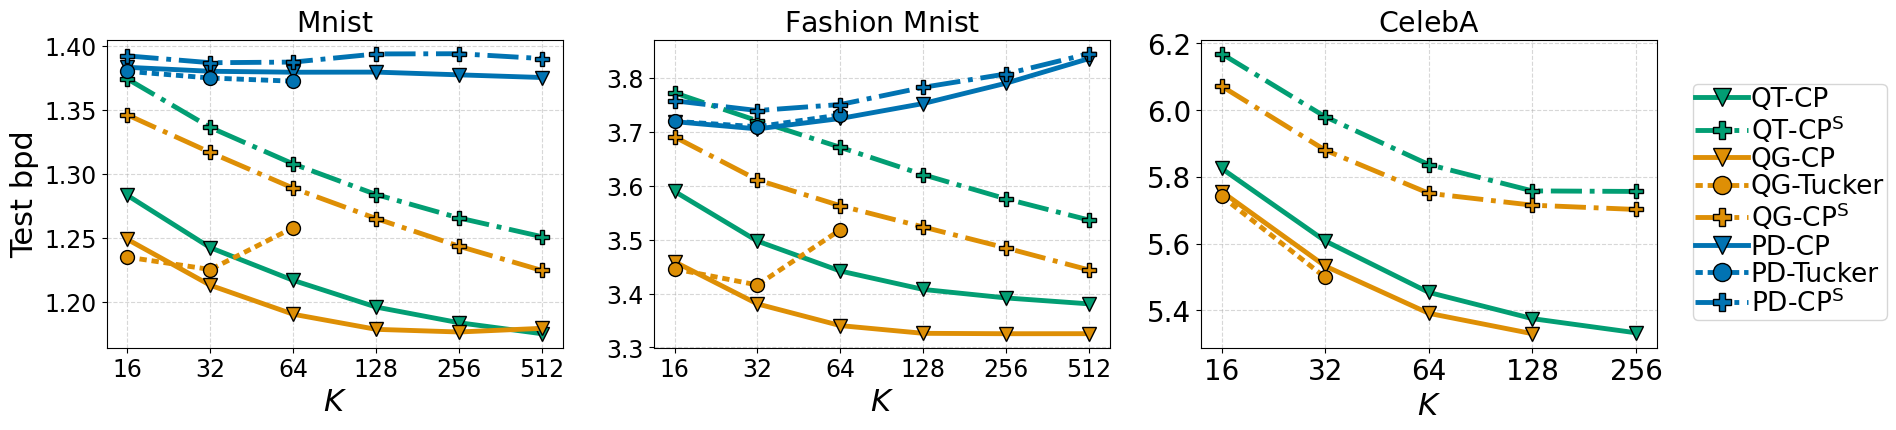

In [6]:
# BPD PLOT (x= "k" OR "num_params", y = "test_bpd")

RESULTS_PATHS = {
    "mnist": "../results/grid_mnist.csv",
    "fashion_mnist": "../results/grid_fashion_mnist.csv",
    "celeba": "../results/grid_celeba.csv"
}

SAVE_PDF_PATH = {
    "mnist": "../results/mnist_bpd.pdf",
    "fashion_mnist": "../results/fashion_mnist_bpd.pdf",
    "celeba": "../results/celeba_bpd.pdf"
}

# Settings for plot
TICK_SIZE = 20
LINE_TICKNESS = 3.5
matplotlib.rcParams.update({'font.size': 17})

X_FIELD = "k" # or "num_params"
Y_FIELD = "Best/Test/bpd"

fig, axes = plt.subplots(nrows=1, ncols=3)

for plot_n, dataset in enumerate(RESULTS_PATHS):
    ax = axes[plot_n]

    # load results data in dataframe
    complete_data: pd.DataFrame = pd.read_csv(RESULTS_PATHS[dataset])


    for rg in RG_LABELS:
        for layer in LAYER_LABELS:

            values_to_plot = complete_data[(complete_data["rg"] == rg) & (complete_data["layer"] == layer)].sort_values(by="k")
            
            # TODO: check if it is correct (should be)
            values_to_plot = values_to_plot.groupby(by="k", as_index=False).mean(numeric_only=True)
            
            if len(values_to_plot) > 0:
                ax.plot(values_to_plot[X_FIELD].map(lambda x: str(int(x))), 
                              values_to_plot[Y_FIELD], 
                              color=RG_COLORS[rg], 
                              lw=LINE_TICKNESS, linestyle=LAYER_LINESTYLES[layer],
                              marker=LAYER_MARKERS[layer], markersize=LAYER_MARKERSIZE[layer], 
                              label=RG_LABELS[rg] + LAYER_LABELS[layer], markeredgecolor='black')

    # Set labels
    ax.set_xlabel("$K$", fontsize=22)
    ax.set_title(DATASET_LABEL[dataset])

    # Set legend
    """
    if dataset == "celeba":
        plt.legend(loc="lower center", bbox_to_anchor=(0.6, 0.6), ncol=2, columnspacing=0.4,
            borderpad=0.1, labelspacing=0.05, markerscale=0.8, handletextpad=0.1)
    elif dataset == "mnist":
        plt.legend(loc="lower center", bbox_to_anchor=(0.6, 0.5), ncol=2, columnspacing=0.4,
                   borderpad=0.1, labelspacing=0.05, markerscale=0.8, handletextpad=0.1)
    """

    # Set ticks and size
    MINOR_Y_TICKS = []
    ax.set_yticks(MINOR_Y_TICKS, minor=True)
    plt.yticks(fontsize=TICK_SIZE)
    plt.xticks(fontsize=TICK_SIZE)

    # Set grid
    ax.grid(True, which='both', alpha=0.5, linestyle="--")

# Set
fig.set_figwidth(20)
fig.set_figheight(4)


axes[0].set_ylabel("Test bpd", fontsize=22)
axes[0].legend(loc="upper left", bbox_to_anchor=(3.45, 0.9), fontsize=19,
               columnspacing=0.4, borderpad=0.1, labelspacing=0.05,
               markerscale=1.3, handletextpad=0.1)

fig.savefig("../results/bpd_not_frozen.pdf", bbox_inches='tight')



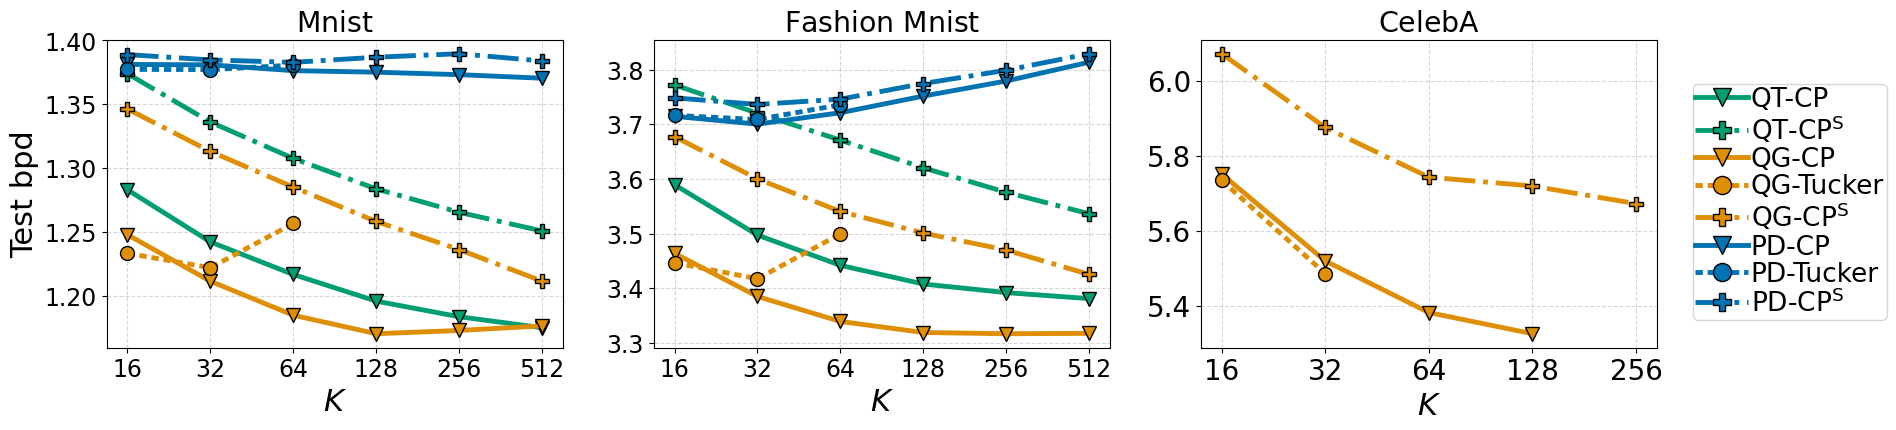

In [7]:
# BPD PLOT FROZEN

RESULTS_PATH = "../results/grid_frozen.csv"
QT_DATA_PATHS = {
    "mnist": "../results/grid_mnist.csv",
    "fashion_mnist": "../results/grid_fashion_mnist.csv",
    "celeba": "../results/grid_celeba.csv"
}

# Settings for plot
TICK_SIZE = 20
LINE_TICKNESS = 3.5
matplotlib.rcParams.update({'font.size': 17})

X_FIELD = "k" # or "num_params"
Y_FIELD = "Best/Test/bpd"

all_data: pd.DataFrame = pd.read_csv(RESULTS_PATH)

fig, axes = plt.subplots(nrows=1, ncols=3)


for plot_n, dataset in enumerate(["mnist", "fashion_mnist", "celeba"]):
    ax = axes[plot_n]

    # load results data in dataframe
    complete_data = all_data[all_data.dataset == dataset]
    qt_data = pd.read_csv(QT_DATA_PATHS[dataset])
    
    for rg in RG_LABELS:
        for layer in LAYER_LABELS:

            if rg == "RQT" and dataset != "celeba":
                values_to_plot = qt_data[(qt_data["rg"] == rg) & (qt_data["layer"] == layer)].sort_values(by="k")
            else:
                values_to_plot = complete_data[(complete_data["rg"] == rg) & (complete_data["layer"] == layer)].sort_values(by="k")

            values_to_plot = values_to_plot.groupby(by="k", as_index=False).mean(numeric_only=True)

            if len(values_to_plot) > 0:
                ax.plot(values_to_plot[X_FIELD].map(lambda x: str(int(x))),
                    values_to_plot[Y_FIELD],
                    color=RG_COLORS[rg],
                    lw=LINE_TICKNESS, linestyle=LAYER_LINESTYLES[layer],
                    marker=LAYER_MARKERS[layer], markersize=LAYER_MARKERSIZE[layer],
                    label=RG_LABELS[rg] + LAYER_LABELS[layer], markeredgecolor='black')

    # Set labels
    ax.set_xlabel("$K$", fontsize=22)
    ax.set_title(DATASET_LABEL[dataset])

    # Set legend
    """
    if dataset == "celeba":
        plt.legend(loc="lower center", bbox_to_anchor=(0.6, 0.6), ncol=2, columnspacing=0.4,
            borderpad=0.1, labelspacing=0.05, markerscale=0.8, handletextpad=0.1)
    elif dataset == "mnist":
        plt.legend(loc="lower center", bbox_to_anchor=(0.6, 0.5), ncol=2, columnspacing=0.4,
                   borderpad=0.1, labelspacing=0.05, markerscale=0.8, handletextpad=0.1)
    """

    # Set ticks and size
    MINOR_Y_TICKS = []
    ax.set_yticks(MINOR_Y_TICKS, minor=True)
    plt.yticks(fontsize=TICK_SIZE)
    plt.xticks(fontsize=TICK_SIZE)

    # Set grid
    ax.grid(True, which='both', alpha=0.5, linestyle="--")

# Set
fig.set_figwidth(20)
fig.set_figheight(4)


axes[0].set_ylabel("Test bpd", fontsize=22)
axes[0].legend(loc="upper left", bbox_to_anchor=(3.45, 0.9), fontsize=19,
               columnspacing=0.4, borderpad=0.1, labelspacing=0.05,
               markerscale=1.3, handletextpad=0.1)

fig.savefig("../results/bpd_frozen.pdf", bbox_inches='tight')



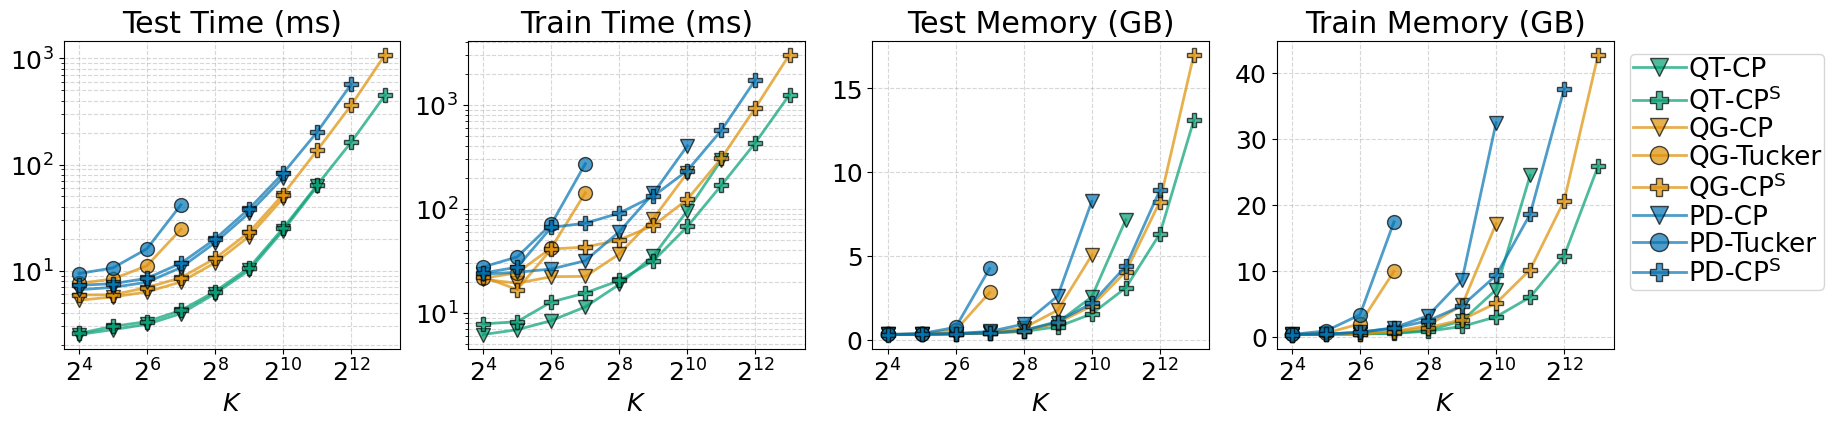

In [8]:
# Benchmarking plots

# Matplotlib settings
LINE_TICKNESS = 2
TICK_SIZE = 10
LEGEND_SIZE = 18
matplotlib.rcParams.update({'font.size': 18})

BENCHMARKING_RESULTS_PATH = "../results/benchmarking_amari.csv"
BENCHMARKING_SAVE_PATH = "../results/bench_28.pdf"

benchmarking_plot(BENCHMARKING_RESULTS_PATH, BENCHMARKING_SAVE_PATH, 
                  min_k=1, max_k=4096, line_tickness=2, tick_size=10, legend_size=18)

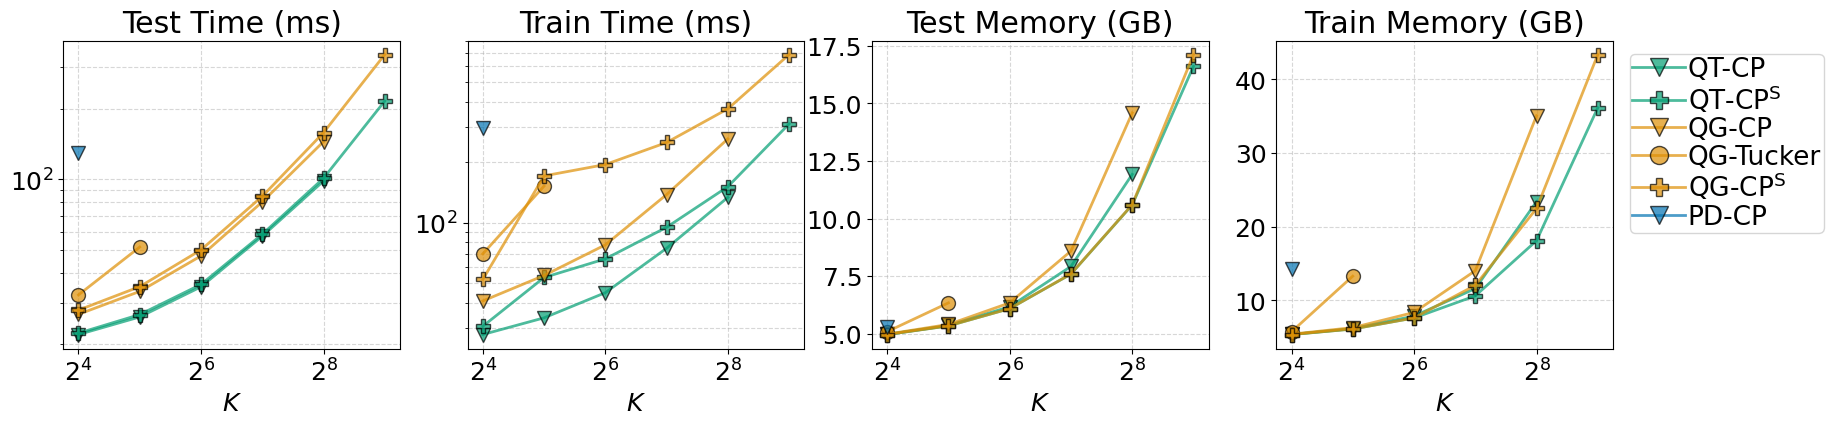

In [9]:
# Benchmarking plots CELEBA
matplotlib.rcParams.update({'font.size': 18})
benchmarking_plot("../results/benchmarking_celeba.csv", "../results/bench_64.pdf", min_k=1, max_k=4096, line_tickness=2)


1
1
1
1
1


C:\Users\anton\AppData\Local\Temp\ipykernel_10460\1423338304.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot["rank"] = data_to_plot["path"].apply(lambda s: extract_rank(s))
C:\Users\anton\AppData\Local\Temp\ipykernel_10460\1423338304.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot["rank"] = data_to_plot["path"].apply(lambda s: extract_rank(s))
C:\Users\anton\AppData\Local\Temp\ipykernel_10460\1423338304.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy

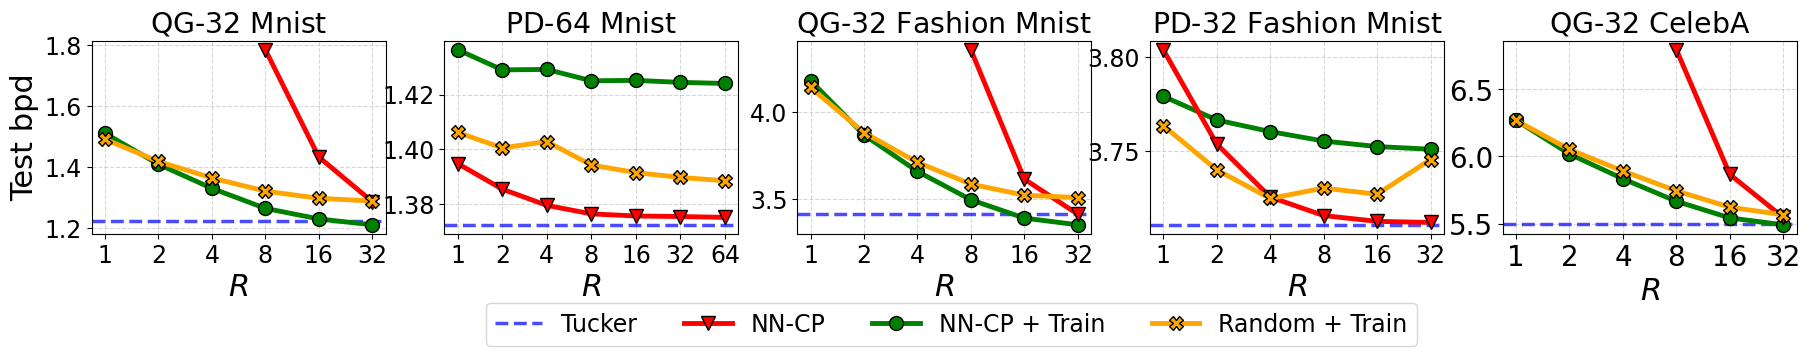

In [12]:
import re
import os


# Compression plot
COMPRESSION_RESULTS_PATH = "../results/compression_bpd.csv"

Y_NAME = "test_bpd"

NN_CP_START_FROM = 8

# Settings for plot
TICK_SIZE = 20
LINE_TICKNESS = 3.5
matplotlib.rcParams.update({'font.size': 17})




with PdfPages("../results/compression.pdf") as pdf:
    
    n_plot = 1
    fig, axes = plt.subplots(nrows=1, ncols=5)
    
    for dataset in ["mnist", "fashion_mnist", "celeba"]:
    
        # load results data in dataframe
        complete_data: pd.DataFrame = pd.read_csv(COMPRESSION_RESULTS_PATH)
    
        if dataset == "mnist":
            models = ["QG_32", "PD_64"]
        elif dataset == "fashion_mnist":
            models = ["QG_32", "PD_32"]
        else:
            models = ["QG_32"]
    
    
        for model in models:

            ax = axes[n_plot-1]
            check_fun = lambda row: bool(re.search("/" + dataset, row.path)) and bool(re.search(model, row.path))
            data_to_plot = complete_data[complete_data.apply(check_fun, axis=1)]
            
            # Line for tucker model
            tucker_data = data_to_plot[data_to_plot.apply(lambda s: bool(re.search("tucker", s.path)), axis=1)]
            print(len(tucker_data))
            assert len(tucker_data) == 1                
            ax.axhline(y=tucker_data[Y_NAME].iloc[0], color='b', linestyle='--', 
                         lw=LINE_TICKNESS - 1, alpha=0.7, label="Tucker")
            
            # Plot other models
            def extract_rank(string_path):
                string_path = os.path.splitext(os.path.basename(string_path))[0]
                match = re.search(r'\d+', string_path)
                if match:
                    return int(match.group())
                else:
                    return -1
            
            data_to_plot["rank"] = data_to_plot["path"].apply(lambda s: extract_rank(s))
            
            # fine-tuned 
            fine_tuned_check = lambda row: bool(re.search("finetuned", row.path))
            fine_tuned_data = data_to_plot[data_to_plot.apply(fine_tuned_check, axis=1)].sort_values(by="rank")
            
            # pre fine-tuned
            pre_fine_tuned_check = lambda row: not bool(re.search("finetuned", row.path)) and not \
                                                 bool(re.search("tucker", row.path)) and not \
                                                 bool(re.search("from_scratch", row.path))
            pre_fine_tuned_data = data_to_plot[data_to_plot.apply(pre_fine_tuned_check, axis=1)].sort_values(by="rank")
            # filter them
            if not model.startswith("PD"):
                pre_fine_tuned_data = pre_fine_tuned_data[pre_fine_tuned_data["rank"] >= NN_CP_START_FROM]
            
            # from scratch
            from_scratch_check = lambda row: bool(re.search("from_scratch", row.path)) 
            from_scratch_data = data_to_plot[data_to_plot.apply(from_scratch_check, axis=1)].sort_values(by="rank")
            
            ax.plot(fine_tuned_data["rank"].map(lambda x: str(x)),
                    fine_tuned_data[Y_NAME],
                    color="g",
                    lw=LINE_TICKNESS, linestyle="-",
                    marker="o", markersize=10,
                    label="NN-CP + Train", markeredgecolor='black')
    
            # plot pre-fine-tuned
            ax.plot(pre_fine_tuned_data["rank"].map(lambda x: str(x)),
                    pre_fine_tuned_data[Y_NAME],
                    color="r",
                    lw=LINE_TICKNESS, linestyle="-",
                    marker="v", markersize=10,
                    label="NN-CP", markeredgecolor='black')
            
            # plot from scratch
            ax.plot(from_scratch_data["rank"].map(lambda x: str(x)),
                    from_scratch_data[Y_NAME],
                    color='orange',
                    lw=LINE_TICKNESS, linestyle="-",
                    marker="X", markersize=10,
                    label="Random + Train", markeredgecolor='black')
            
            ax.set_xlabel("$R$", fontsize=22)
            ax.set_title(f"{model.replace('_', '-')} {DATASET_LABEL[dataset]}")
            
            if n_plot == 1:
                ax.legend()
                handles, labels = ax.get_legend_handles_labels()
                order = [0,2,1, 3]
                ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                          loc="upper left", ncol=4, bbox_to_anchor=(1.3,-0.3))
                ax.set_ylabel("Test bpd", fontsize=22)
    

    
            # Set grid
            ax.grid(True, which='both', alpha=0.5, linestyle="--")
            plt.yticks(fontsize=TICK_SIZE)
            plt.xticks(fontsize=TICK_SIZE)
            
            n_plot += 1

    fig.set_figwidth(22)
    fig.set_figheight(2.5)
    pdf.savefig(fig, bbox_inches='tight')



# Plots for appendix

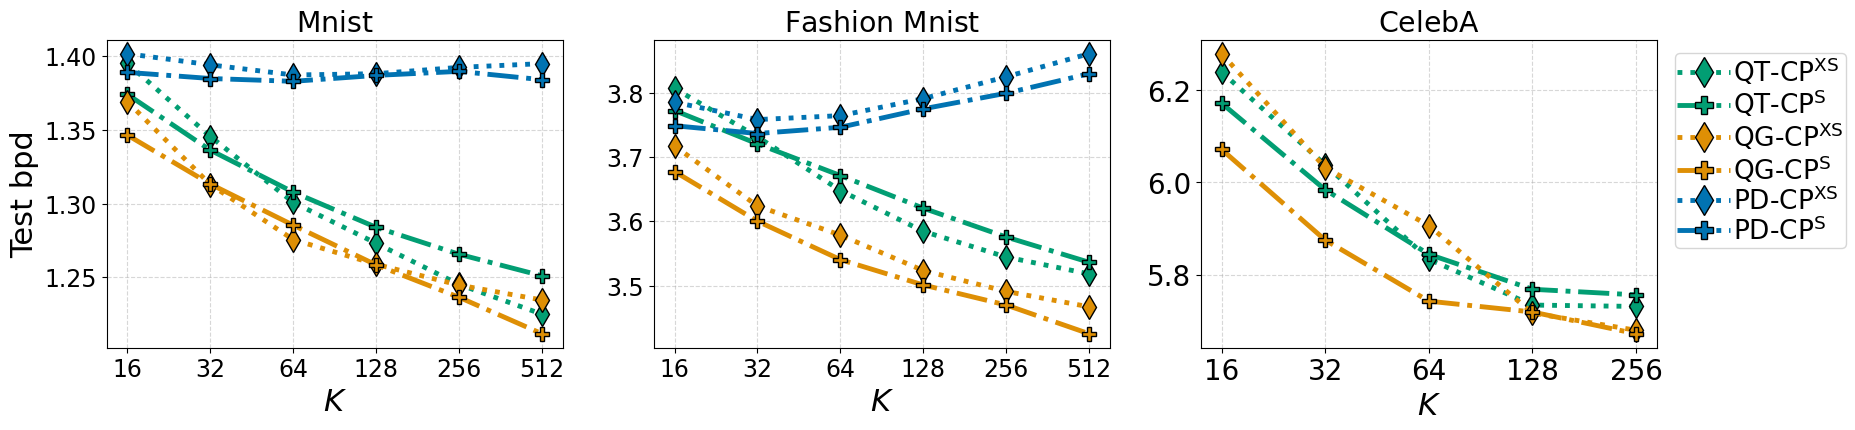

In [9]:
# BPD PLOT FROZEN

RESULTS_PATH = "../results/grid_frozen.csv"
QT_DATA_PATHS = {
    "mnist": "../results/grid_mnist.csv",
    "fashion_mnist": "../results/grid_fashion_mnist.csv",
    "celeba": "../results/grid_celeba.csv"
}

SHARED_LAYER_LABELS = {
    "cp-shared": "$\\text{CP}^{\\text{XS}}$",
    "cp-shared-new": "$\\text{CP}^{\\text{S}}$"
}

# Settings for plot
TICK_SIZE = 20
LINE_TICKNESS = 3.5
matplotlib.rcParams.update({'font.size': 17})

X_FIELD = "k" # or "num_params"
Y_FIELD = "Best/Test/bpd"

all_data: pd.DataFrame = pd.read_csv(RESULTS_PATH)

fig, axes = plt.subplots(nrows=1, ncols=3)


for plot_n, dataset in enumerate(["mnist", "fashion_mnist", "celeba"]):
    ax = axes[plot_n]

    # load results data in dataframe
    complete_data = all_data[all_data.dataset == dataset]
    qt_data = pd.read_csv(QT_DATA_PATHS[dataset])

    for rg in RG_LABELS:
        for layer in SHARED_LAYER_LABELS:

            if rg == "RQT":
                values_to_plot = qt_data[(qt_data["rg"] == rg) & (qt_data["layer"] == layer)].sort_values(by="k")
            else:
                values_to_plot = complete_data[(complete_data["rg"] == rg) & (complete_data["layer"] == layer)].sort_values(by="k")

            # TODO: check if it is correct (should be)
            values_to_plot = values_to_plot.groupby(by="k", as_index=False).mean(numeric_only=True)

            ax.plot(values_to_plot[X_FIELD].map(lambda x: str(int(x))),
                    values_to_plot[Y_FIELD],
                    color=RG_COLORS[rg],
                    lw=LINE_TICKNESS, linestyle=LAYER_LINESTYLES[layer],
                    marker=LAYER_MARKERS[layer], markersize=LAYER_MARKERSIZE[layer],
                    label=RG_LABELS[rg] + SHARED_LAYER_LABELS[layer], markeredgecolor='black')

    # Set labels
    ax.set_xlabel("$K$", fontsize=22)
    ax.set_title(DATASET_LABEL[dataset])

    # Set legend
    """
    if dataset == "celeba":
        plt.legend(loc="lower center", bbox_to_anchor=(0.6, 0.6), ncol=2, columnspacing=0.4,
            borderpad=0.1, labelspacing=0.05, markerscale=0.8, handletextpad=0.1)
    elif dataset == "mnist":
        plt.legend(loc="lower center", bbox_to_anchor=(0.6, 0.5), ncol=2, columnspacing=0.4,
                   borderpad=0.1, labelspacing=0.05, markerscale=0.8, handletextpad=0.1)
    """

    # Set ticks and size
    MINOR_Y_TICKS = []
    ax.set_yticks(MINOR_Y_TICKS, minor=True)
    plt.yticks(fontsize=TICK_SIZE)
    plt.xticks(fontsize=TICK_SIZE)

    # Set grid
    ax.grid(True, which='both', alpha=0.5, linestyle="--")

# Set
fig.set_figwidth(20)
fig.set_figheight(4)


axes[0].set_ylabel("Test bpd", fontsize=22)
axes[2].legend(loc="upper left", bbox_to_anchor=(1.01, 1.0), fontsize=19,
               columnspacing=0.4, borderpad=0.1, labelspacing=0.05,
               markerscale=1.3, handletextpad=0.1)

fig.savefig("../results/bpd_shared_comparison.pdf", bbox_inches='tight')


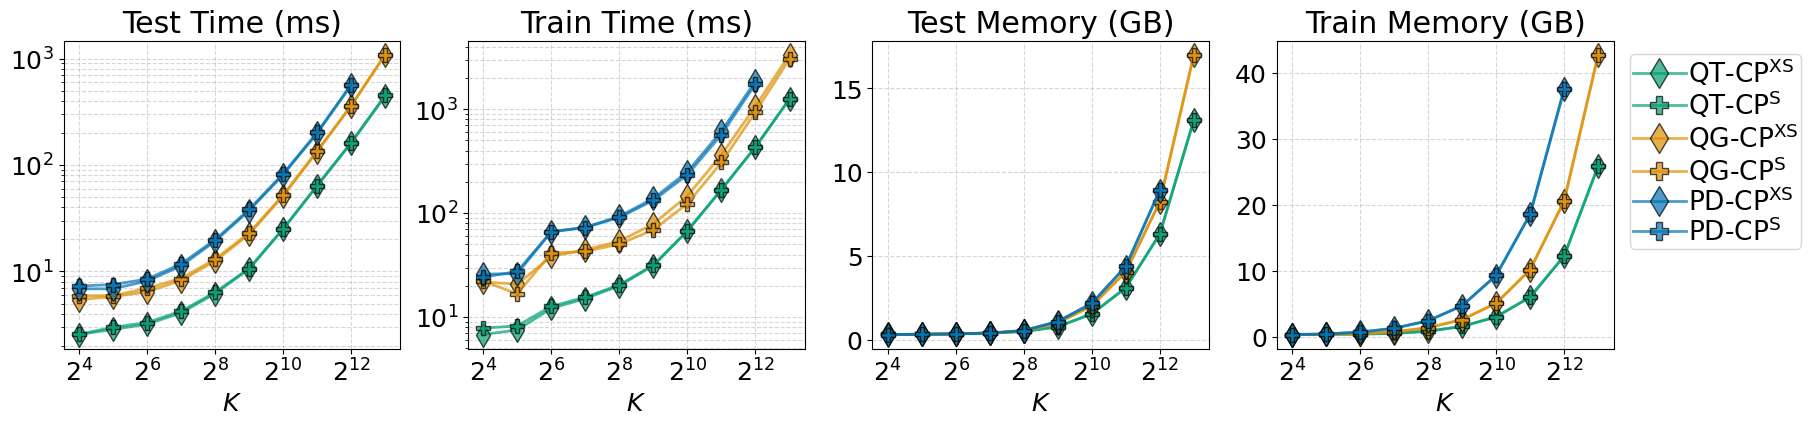

In [10]:
# Benchmarking plots

BENCHMARKING_RESULTS_PATH = "../results/benchmarking_amari.csv"
BENCHMARKING_SAVE_PATH = "../results/bench_shared_comparison.pdf"

benchmarking_plot(BENCHMARKING_RESULTS_PATH, BENCHMARKING_SAVE_PATH, layer_labels=SHARED_LAYER_LABELS)
